# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd

__Comments__\
Region name is the zipcode.
RegionID not relevant to the analysis.

In [2]:
df = pd.read_csv('Zillow_data/zhvi_all-homes_zipcode.csv')
df.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,233265.0,...,1248340.0,1234262.0,1229890.0,1226466.0,1208024.0,1182758.0,1150900.0,1134880.0,1120949.0,1112549.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,211748.0,...,494425.0,493485.0,492514.0,491726.0,491562.0,492618.0,494017.0,494766.0,494546.0,494435.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,245773.0,...,1161916.0,1153259.0,1156287.0,1175142.0,1193746.0,1205413.0,1203165.0,1209735.0,1211403.0,1212520.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30443 entries, 0 to 30442
Columns: 303 entries, RegionID to 2020-06-30
dtypes: float64(294), int64(3), object(6)
memory usage: 70.4+ MB


In [4]:
percent_zip_codes = str(round((30443/41702)*100,2))
print ('The data set includes ' + percent_zip_codes + '% of US zip codes')

The data set includes 73.0% of US zip codes


__Notes__
- Dropping Metro column because of missing values
- State and StateName are dupliates
- RegionID, RegionType not relevant

In [5]:
#rename RegionName to ZipCode
df.rename(columns={'RegionName': 'zipcode'}, inplace=True)
#drop RegionID
df.drop(columns=['RegionID', 'RegionType', 'StateName', 'SizeRank'], inplace=True)
df.head(2)

,zipcode,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,10025,NY,New York,New York-Newark-Jersey City,New York County,233265.0,231813.0,231891.0,231866.0,232396.0,...,1248340.0,1234262.0,1229890.0,1226466.0,1208024.0,1182758.0,1150900.0,1134880.0,1120949.0,1112549.0
1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,211748.0,211591.0,211180.0,211044.0,210477.0,...,494425.0,493485.0,492514.0,491726.0,491562.0,492618.0,494017.0,494766.0,494546.0,494435.0


In [6]:
def melt_data_monthly_mean(df):
    melted = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'CountyName', 'Metro'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [7]:
melt_data_monthly_mean(df) #this is the mean price by month

,value
time,
1996-01-31,124979.207863
1996-02-29,124606.091938
1996-03-31,124543.916218
1996-04-30,124573.163709
1996-05-31,124632.428195
...,...
2020-02-29,227757.147127
2020-03-31,228465.291561
2020-04-30,229086.276320


In [8]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'CountyName', 'Metro'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

#value_name='df_melted'

In [9]:
df = melt_data(df)
df.head(2)

,zipcode,City,State,CountyName,Metro,time,value
0,10025,New York,NY,New York County,New York-Newark-Jersey City,1996-01-31,233265.0
1,60657,Chicago,IL,Cook County,Chicago-Naperville-Elgin,1996-01-31,211748.0


__Missing Values__
- the only column with missing values is the 'Metro' column, so it is reasonable to assume that these rows are not in a metro area. Missing values were replaced with 'rural'.

In [10]:
df.isna().sum()

zipcode             0
City                0
State               0
CountyName          0
Metro         1252330
time                0
value               0
dtype: int64

In [11]:
df.fillna('rural', inplace=True)

In [12]:
df.isna().sum()

zipcode       0
City          0
State         0
CountyName    0
Metro         0
time          0
value         0
dtype: int64

In [13]:
df.dtypes

zipcode                int64
City                  object
State                 object
CountyName            object
Metro                 object
time          datetime64[ns]
value                float64
dtype: object

In [14]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('<M8[ns]'), dtype('float64')],
      dtype=object)

In [15]:
df['value'] = df['value'].astype('int')

In [16]:
df.dtypes

zipcode                int64
City                  object
State                 object
CountyName            object
Metro                 object
time          datetime64[ns]
value                  int64
dtype: object

# Step 2: Data Preprocessing

In [17]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [18]:
# get_datetimes(df)

# Step 3: EDA and Visualization

__EDA Questions__
1. Which 3 zip codes had the most volatile prices?
2. Which 3 zip codes had the most stable prices?
3. Which zip codes are seeing price decay?
4. Which (if any) zip codes saw price growth during the 2008-2012 recession?
5. Which zip codes had stable prices during the 2008-2012 recession?
6. Which zip codes are priced the lowest?
7. Which zip codes are priced the highest?
8. How much higher, on average, are prices in metro areas?
9. What was the net change in overall median price from 2009-2019?
10. Which zip codes had a percent increase greater than inflation in the last year?

What do different regions look like?
What are the top cities?
Where was the top growth in the last 5 years, 10 years?

In [19]:
df.nlargest(3, ['value'])

,zipcode,City,State,CountyName,Metro,time,value
8840789,94027,Atherton,CA,San Mateo County,San Francisco-Oakland-Hayward,2020-03-31,6518578
8871232,94027,Atherton,CA,San Mateo County,San Francisco-Oakland-Hayward,2020-04-30,6515411
8810346,94027,Atherton,CA,San Mateo County,San Francisco-Oakland-Hayward,2020-02-29,6459116


In [20]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

NameError: name 'matplotlib' is not defined

# Step 4: Reshape from Wide to Long Format

In [21]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

## Testing methods on DC zipcodes

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6844134 entries, 0 to 8950241
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   zipcode     int64         
 1   City        object        
 2   State       object        
 3   CountyName  object        
 4   Metro       object        
 5   time        datetime64[ns]
 6   value       int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 417.7+ MB


In [23]:
dc_codes = [20009, 20001, 20005, 20036, 20006]

In [24]:
dc = df[df['zipcode'].isin(dc_codes)]

In [25]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 43 to 8937796
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   zipcode     1451 non-null   int64         
 1   City        1451 non-null   object        
 2   State       1451 non-null   object        
 3   CountyName  1451 non-null   object        
 4   Metro       1451 non-null   object        
 5   time        1451 non-null   datetime64[ns]
 6   value       1451 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 90.7+ KB


In [26]:
dc.head()

,zipcode,City,State,CountyName,Metro,time,value
43,20009,Washington,DC,District of Columbia,Washington-Arlington-Alexandria,1996-01-31,146980
237,20001,Washington,DC,District of Columbia,Washington-Arlington-Alexandria,1996-01-31,135691
5692,20005,Washington,DC,District of Columbia,Washington-Arlington-Alexandria,1996-01-31,116901
10252,20036,Washington,DC,District of Columbia,Washington-Arlington-Alexandria,1996-01-31,98998
30486,20009,Washington,DC,District of Columbia,Washington-Arlington-Alexandria,1996-02-29,146401


In [27]:
dc.set_index('time', inplace=True)

In [28]:
dc = dc[['zipcode', 'value']]
dc.head()

,zipcode,value
time,,
1996-01-31,20009,146980
1996-01-31,20001,135691
1996-01-31,20005,116901
1996-01-31,20036,98998
1996-02-29,20009,146401


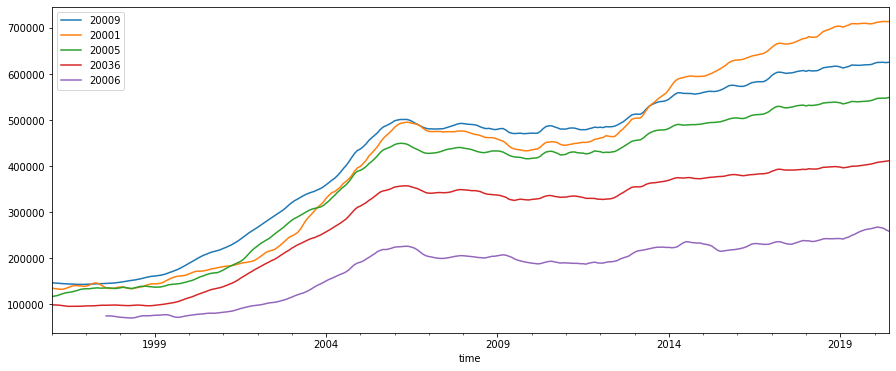

In [51]:
import matplotlib.pyplot as plt 

#Graph trends
for i in range(len(dc_codes)):
    dc.loc[dc['zipcode'] == dc_codes[i]]['value'].plot(label=dc_codes[i], figsize=(15, 6))
    plt.legend()

In [30]:
#Separate df's by zipcode
dc_list = []
for i in range(len(dc_codes)):
    dc_list.append(dc.loc[dc['zipcode'] == dc_codes[i]])
dc_list

[            zipcode   value
 time                       
 1996-01-31    20009  146980
 1996-02-29    20009  146401
 1996-03-31    20009  146087
 1996-04-30    20009  145432
 1996-05-31    20009  145008
 ...             ...     ...
 2020-02-29    20009  625050
 2020-03-31    20009  625248
 2020-04-30    20009  625336
 2020-05-31    20009  624636
 2020-06-30    20009  625364
 
 [294 rows x 2 columns],             zipcode   value
 time                       
 1996-01-31    20001  135691
 1996-02-29    20001  134316
 1996-03-31    20001  133510
 1996-04-30    20001  132833
 1996-05-31    20001  133174
 ...             ...     ...
 2020-02-29    20001  712195
 2020-03-31    20001  713098
 2020-04-30    20001  713916
 2020-05-31    20001  713610
 2020-06-30    20001  713761
 
 [294 rows x 2 columns],             zipcode   value
 time                       
 1996-01-31    20005  116901
 1996-02-29    20005  118258
 1996-03-31    20005  119303
 1996-04-30    20005  121641
 1996-05-31    20005

## Differencing to remove trends & make stationary
Used 2nd order difference.  Previously tried 1 difference, which did not yield stationary results.

In [31]:
dc_diff = []

for code in dc_list:
    dc_diff.append(code['value'].diff().diff().dropna())
dc_diff

[time
 1996-03-31     265.0
 1996-04-30    -341.0
 1996-05-31     231.0
 1996-06-30     107.0
 1996-07-31    -151.0
                ...  
 2020-02-29    -724.0
 2020-03-31   -1541.0
 2020-04-30    -110.0
 2020-05-31    -788.0
 2020-06-30    1428.0
 Name: value, Length: 292, dtype: float64, time
 1996-03-31     569.0
 1996-04-30     129.0
 1996-05-31    1018.0
 1996-06-30    1504.0
 1996-07-31     477.0
                ...  
 2020-02-29      37.0
 2020-03-31    -797.0
 2020-04-30     -85.0
 2020-05-31   -1124.0
 2020-06-30     457.0
 Name: value, Length: 292, dtype: float64, time
 1996-03-31    -312.0
 1996-04-30    1293.0
 1996-05-31    -331.0
 1996-06-30    -361.0
 1996-07-31    -623.0
                ...  
 2020-02-29    -222.0
 2020-03-31   -1809.0
 2020-04-30    -133.0
 2020-05-31    -132.0
 2020-06-30    1443.0
 Name: value, Length: 292, dtype: float64, time
 1996-03-31   -284.0
 1996-04-30   -264.0
 1996-05-31   -370.0
 1996-06-30    218.0
 1996-07-31    190.0
               ... 

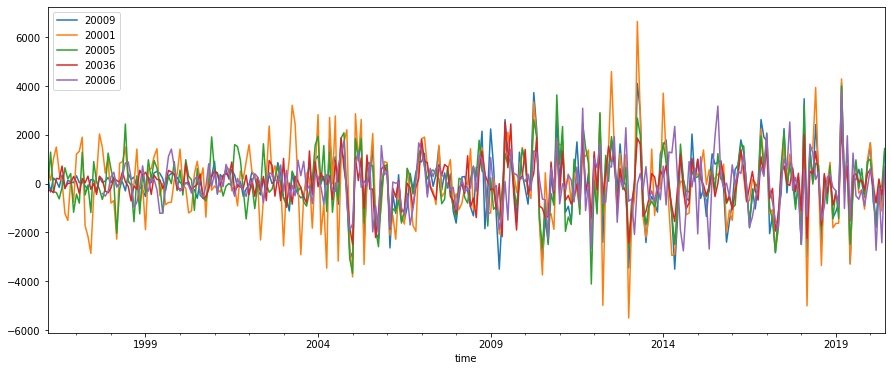

In [32]:
#Graph trends
for i in range(len(dc_codes)):
    dc_diff[i].plot(label=dc_codes[i], figsize=(15, 6))
    plt.legend()

<Figure size 432x288 with 0 Axes>

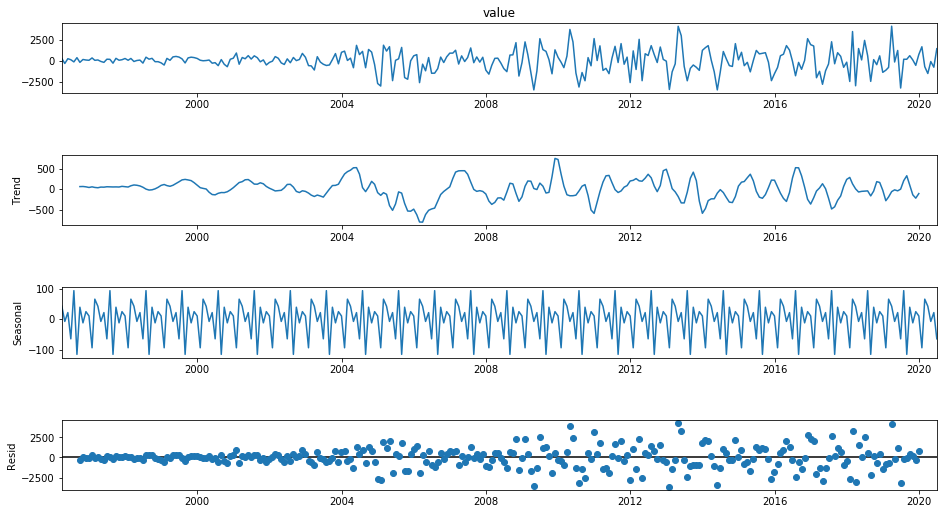

<Figure size 432x288 with 0 Axes>

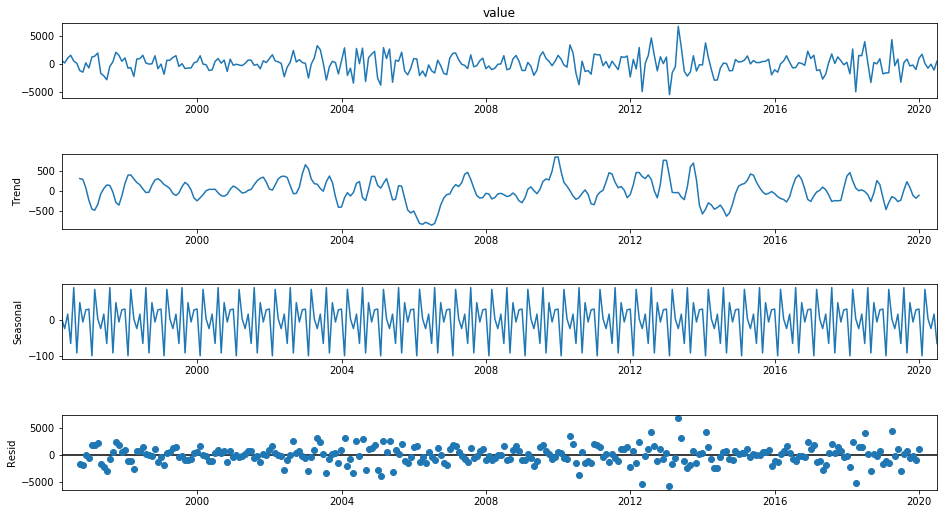

<Figure size 432x288 with 0 Axes>

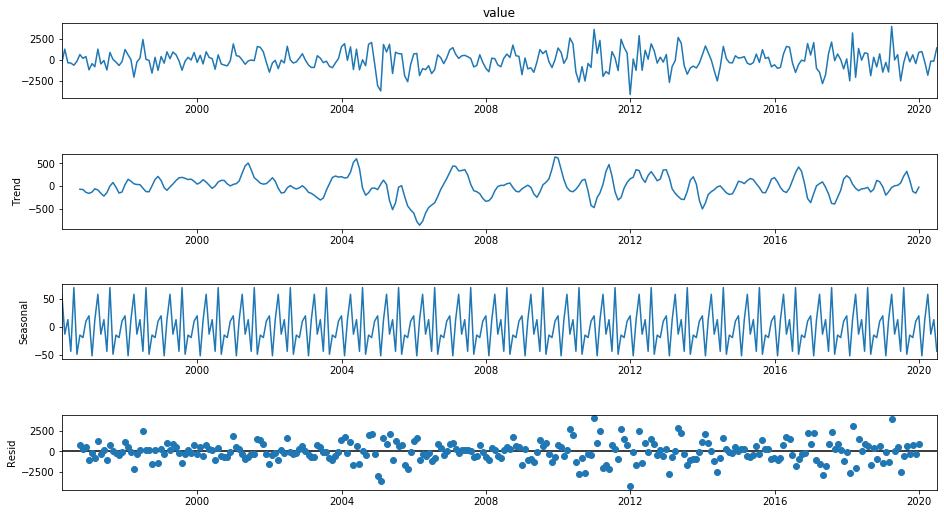

<Figure size 432x288 with 0 Axes>

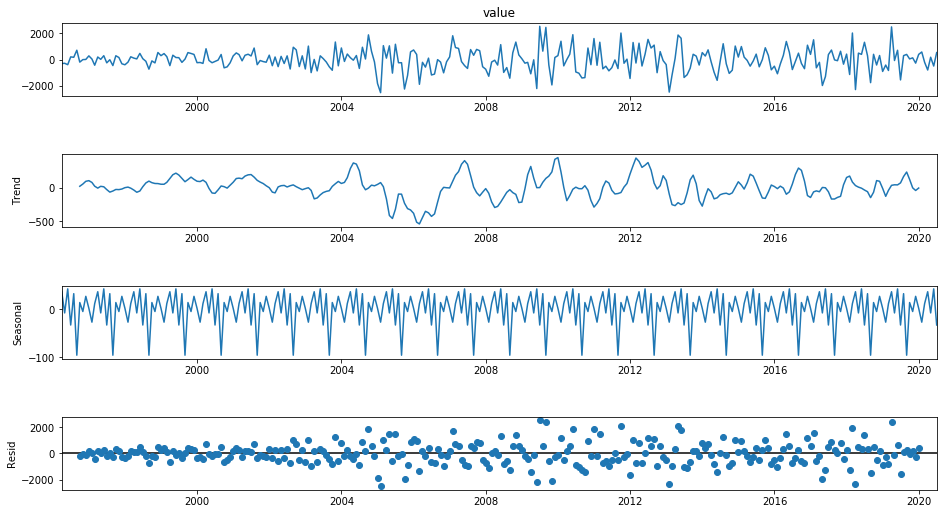

<Figure size 432x288 with 0 Axes>

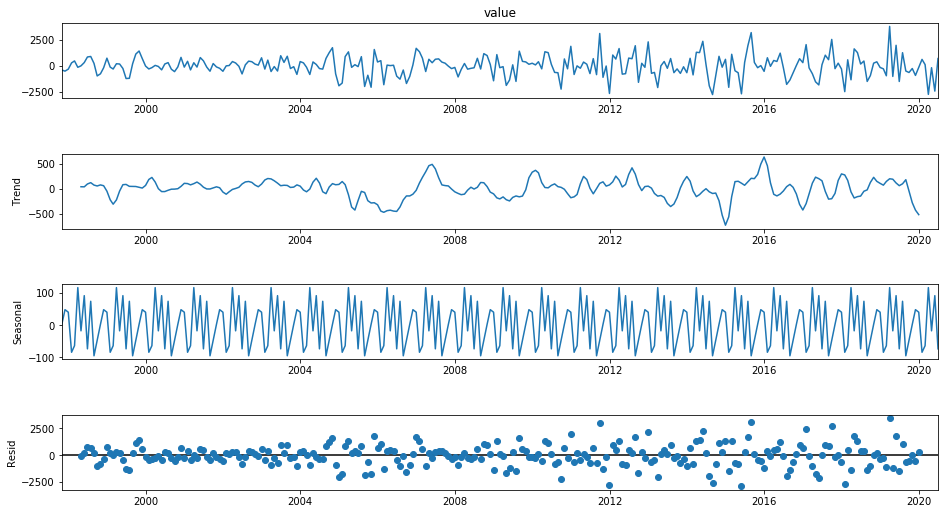

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i in range(len(dc_codes)):
    decomposition = seasonal_decompose(dc_diff[i])
    fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)

In [34]:
from statsmodels.tsa.stattools import adfuller

#Create method to test for stationarity

def test_stationarity(timeseries, window):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

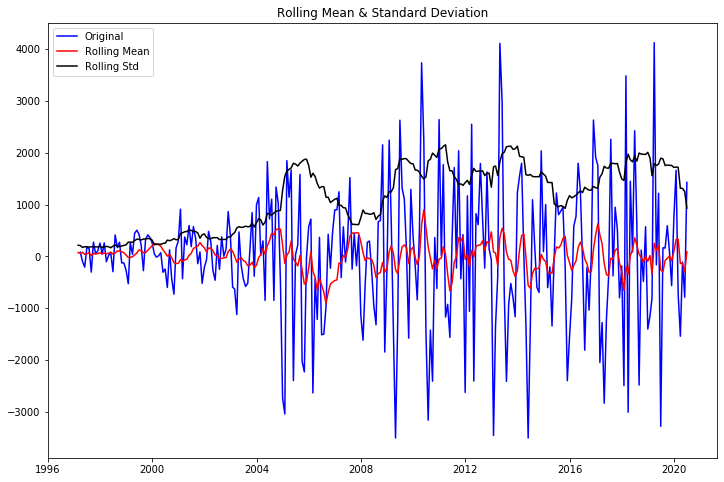

Results of Dickey-Fuller Test:
Test Statistic                -6.451665e+00
p-value                        1.518146e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.770000e+02
Critical Value (1%)           -3.454180e+00
Critical Value (5%)           -2.872031e+00
Critical Value (10%)          -2.572360e+00
dtype: float64


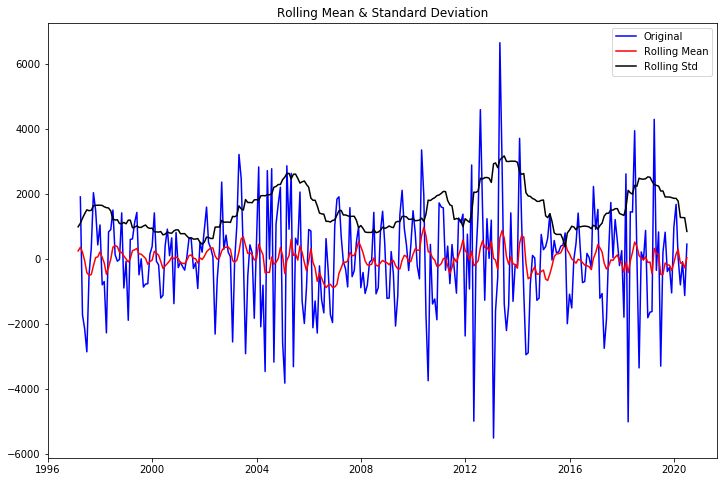

Results of Dickey-Fuller Test:
Test Statistic                -5.651699e+00
p-value                        9.826903e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.760000e+02
Critical Value (1%)           -3.454267e+00
Critical Value (5%)           -2.872070e+00
Critical Value (10%)          -2.572381e+00
dtype: float64


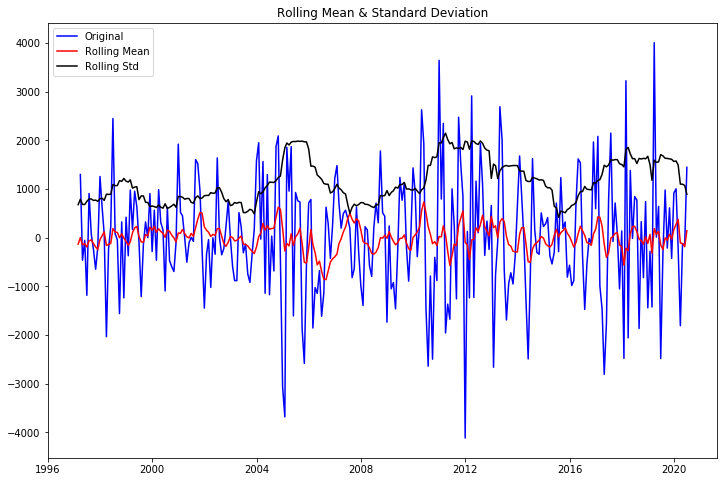

Results of Dickey-Fuller Test:
Test Statistic                -5.894045e+00
p-value                        2.879307e-07
#Lags Used                     1.500000e+01
Number of Observations Used    2.760000e+02
Critical Value (1%)           -3.454267e+00
Critical Value (5%)           -2.872070e+00
Critical Value (10%)          -2.572381e+00
dtype: float64


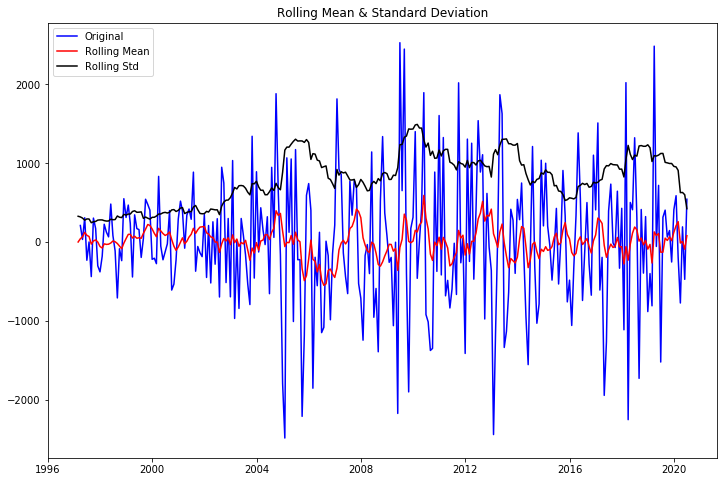

Results of Dickey-Fuller Test:
Test Statistic                  -5.288295
p-value                          0.000006
#Lags Used                      15.000000
Number of Observations Used    276.000000
Critical Value (1%)             -3.454267
Critical Value (5%)             -2.872070
Critical Value (10%)            -2.572381
dtype: float64


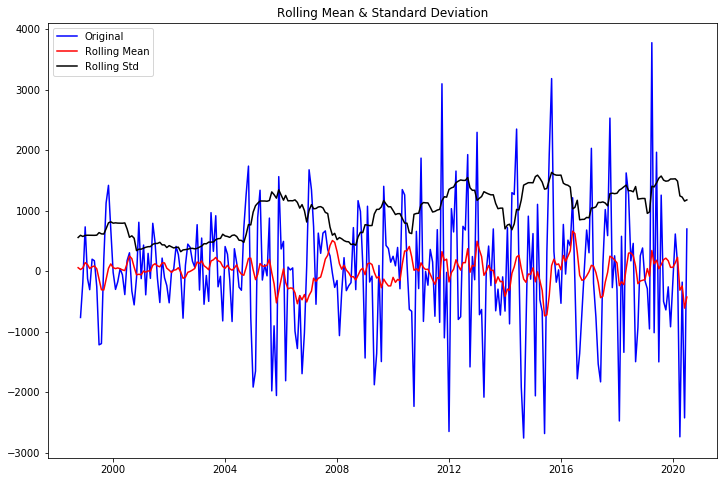

Results of Dickey-Fuller Test:
Test Statistic                -7.825773e+00
p-value                        6.487960e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.610000e+02
Critical Value (1%)           -3.455656e+00
Critical Value (5%)           -2.872678e+00
Critical Value (10%)          -2.572705e+00
dtype: float64


In [35]:
for zipcode in dc_diff:
    test_stationarity(zipcode, 12)

**2nd difference values are now stationary.**

## Now have to check for autocorrelation

### Notes From Lecture (Below)

One we have achieved stationarity the next step in fitting a model to address any autocorrelation that remains in the differenced series. 

Sometimes, we have to difference the differenced data (known as a second difference) to achieve stationary data. <b>The number of times we have to difference our data is the order of differencing</b> - we will use this information when building our model.

One we have achieved stationarity the next step in fitting a model is to address any autocorrelation that remains in the differenced series. 

We will break down what ARIMA is shortly, but for now, we will focus on the I, which stands for **integrated**.  A time series which has been be differenced to become stationary is saidf to have been integrated[1](https://people.duke.edu/~rnau/411arim.htm). 

There is an order parameter in ARIMA with three slots: (p, d, q).  d represents our order of differencing, so putting a one there in our model will apply a first order difference.

In [36]:
from statsmodels.tsa.arima_model import ARIMA

dc_models = []
dc_preds = []

for i in range(len(dc_list)):
    model_data = dc_list[i].drop('zipcode', axis=1)
    model = ARIMA(model_data, (3,2,0)).fit()
    dc_models.append(model)
    dc_preds.append(dc_models[i].predict(typ='levels'))

/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/bas

In [37]:
dc_models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.value   No. Observations:                  292
Model:                 ARIMA(3, 2, 0)   Log Likelihood               -2460.154
Method:                       css-mle   S.D. of innovations           1102.123
Date:                Tue, 18 Aug 2020   AIC                           4930.308
Time:                        13:45:44   BIC                           4948.692
Sample:                    03-31-1996   HQIC                          4937.672
                         - 06-30-2020                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.0623     47.555      0.085      0.932     -89.143      97.268
ar.L1.D2.value     0.0905      0.052      1.747      0.081      -0.011       0.192
ar.L2.D2.value     0.0099      0.052      0.191      0.849      -0.092       0.112
ar.L3.D2.value    -0.4611      0.052     -8.934      0.000      -0.562      -0.360
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6795           -1.0769j            1.2734           -0.1604
AR.2            0.6795           +1.0769j            1.2734            0.1604
AR.3           -1.3375           -0.0000j            1.3375           -0.5000
-----------------------------------------------------------------------------
"""

In [43]:
dc_preds[0]

1996-03-31    145826.062266
1996-04-30    145804.429052
1996-05-31    144732.876135
1996-06-30    144484.859032
1996-07-31    144548.732646
                  ...      
2020-02-29    626197.643575
2020-03-31    626407.078327
2020-04-30    624539.029681
2020-05-31    625738.083049
2020-06-30    624579.642347
Freq: M, Length: 292, dtype: float64

In [44]:
dc_list[0]

,zipcode,value
time,,
1996-01-31,20009,146980
1996-02-29,20009,146401
1996-03-31,20009,146087
1996-04-30,20009,145432
1996-05-31,20009,145008
...,...,...
2020-02-29,20009,625050
2020-03-31,20009,625248
2020-04-30,20009,625336


## Plot PACF to determine best AR terms

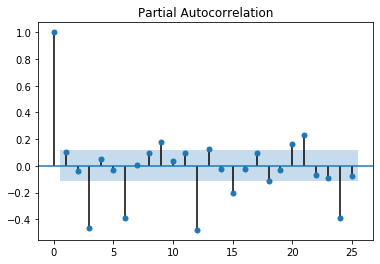

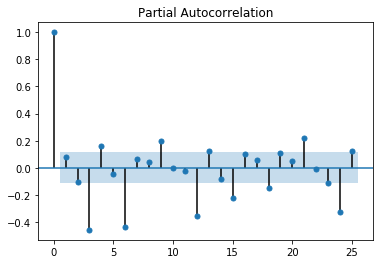

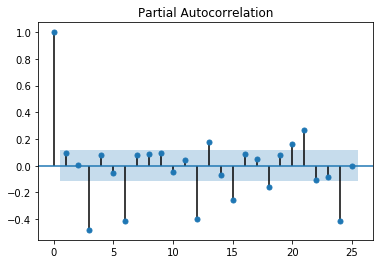

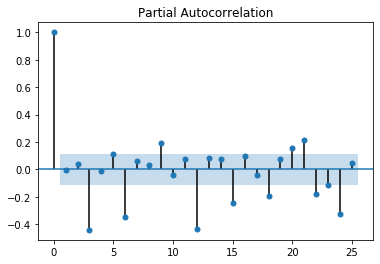

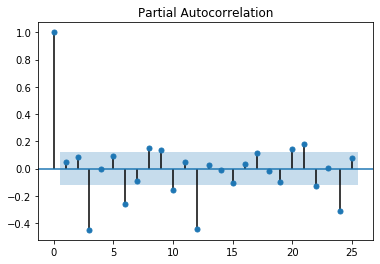

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for i in range(len(dc_list)):
    plot_pacf(dc_list[i].drop('zipcode', axis=1).diff().diff().dropna());

**High positive values at k == 0 means that we should use an AR term of 0 in our ARIMA model.**

## Get Optimal Terms

In [ ]:
!pip install pmdarima

In [42]:
from pmdarima import auto_arima

test_best = dc_list[0].drop('zipcode', axis=1)
auto_arima(test_best, start_p=0, start_q=0, max_p=6, max_q=3, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4998.254, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5000.166, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5000.165, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4996.265, Time=0.01 sec


/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5002.148, Time=0.23 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.412 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, with_intercept=False)

## Try Forecasting

In [45]:
forecast = dc_models[0].forecast(steps = 60)

ValueError: could not broadcast input array from shape (60,2) into shape (60)

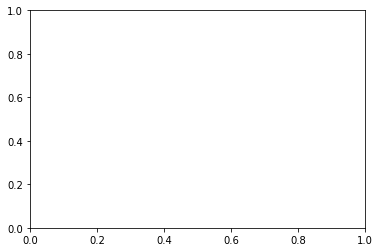

In [50]:
fig, ax = plt.subplots()

# ax.plot(dc_list[0])
ax.plot(forecast)
ax.set_title('Chicago Gun Crime Predictions\n One Year out');

# Step 6: Interpreting Results